## IMPORTANT- ensure main.py file is up to date

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
import sys
import os
import tensorflow as tf
%matplotlib notebook


In [19]:
def binary_search(sorted_list, target, ind):  # returns index of first value >=target
    # sorted list is assumed to contain (x,y,z) coordinates. search is done based on ind coordinate (i.e. ind = 0 means x)
    # returns len(sorted_list) if not found
    lo = 0
    hi = len(sorted_list) - 1
    while lo < hi - 1:
        mid = (lo + hi) // 2
        if sorted_list[mid][ind] >= target:
            hi = mid
        else:
            lo = mid
    if target > sorted_list[hi][ind]:
        return len(sorted_list)
    return lo if sorted_list[lo][ind] >= target else hi

In [39]:
def smooth_data(data,kernel_size = 20):#smooth some time series data with kernel
    kernel = np.ones(kernel_size)/kernel_size
    return np.convolve(data,kernel,mode='same')

In [101]:
class Connectome:
    # attr
    # node_locations: maps node names to (x,y,z) coords
    # names: list of node names
    # coordinates: list of (x,y,z) coords, sorted by increasing x, with order corresponding to names
    # ie node names[i] has coordinate coordinates[i]
    def __init__(self, G):
        self.G = G
        self.n_nodes = G.number_of_nodes()
        
        Xs = nx.get_node_attributes(G, 'x')
        Ys = nx.get_node_attributes(G, 'y')
        Zs = nx.get_node_attributes(G, 'z')
        
        self.node_dict = dict()
        self.lo_bound = []  # [min x, min y, min z]
        self.hi_bound = []  # [max x, max y, max z]
        for node in list(G.nodes):
            try:
                if float(Xs[node]) > 80:
                    continue
                self.node_dict[node] = [float(Xs[node]), float(Ys[node]), float(Zs[node])]
                if len(self.lo_bound) == 0:
                    self.lo_bound = self.node_dict[node][:]
                    self.hi_bound = self.node_dict[node][:]
                else:
                    for ind in range(3):
                        self.lo_bound[ind] = min(self.lo_bound[ind], self.node_dict[node][ind])
                        self.hi_bound[ind] = max(self.hi_bound[ind], self.node_dict[node][ind])
            except KeyError:
                pass
        
        
        self.coordinates = []  # extract [x,y,z] nodes
        self.names = []  # extract names
        for node, coord in self.node_dict.items():
            self.coordinates.append(coord)
            self.names.append(node)
        self.coordinates = np.asarray(self.coordinates)
        self.names = np.asarray(self.names)
        reorder = self.coordinates[:, 1].argsort()
        self.coordinates = self.coordinates[reorder]
        self.names = self.names[reorder]

    #use this to 3d plot null and empirical networks
    def plot_nodes(self,node_names,edges=None,display_labels=False):
        #node_names - all nodes to be plotted
        #edges- list of edges. if None, will be taken from empirical network

        if len(node_names)==0:
            return False


        if edges==None:
            edges = []
            seen_nodes = set()
            for node in node_names:
                for neighbor in self.G.neighbors(node):
                    if neighbor in seen_nodes:
                        edges.append([node, neighbor])
                seen_nodes.add(node)

        x_plots = [self.node_dict[name][0] for name in node_names]
        y_plots = [self.node_dict[name][1] for name in node_names]
        z_plots = [self.node_dict[name][2] for name in node_names]
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.scatter(x_plots, y_plots, z_plots, s=30, color='blue')

        if display_labels:
            for node in node_names:
                ax.text(*self.node_dict[node],node,size=10,zorder=1,color='k')

        for node1, node2 in edges:
            plt_args = [[self.node_dict[node1][i], self.node_dict[node2][i]] for i in range(3)]
            ax.plot(*plt_args)
        plt.show()

        return True

    def plot_random_cube(self,cube_dim):
        success = False
        while not success:
            bounds = self.get_random_bounds(cube_dim)
            names, _ = self.get_cube(bounds,cube_dim)
            success = self.plot_nodes(names)

    # get random bounds for a cube to parse
    def get_random_bounds(self, cube_dim):
        center = [np.random.uniform(self.lo_bound[ind], self.hi_bound[ind]) for ind in range(3)]
        return [coord - (cube_dim / 2) for coord in center]

    def get_restricted_bounds(self,cube_dim,restriction,above):
        #get bounds, not past z-coordinate give by restriction
        #if above==True, bounds will be given such that cube lies above restriction. If above==False, cube will lie below restriction
        center = [np.random.uniform(self.lo_bound[ind], self.hi_bound[ind]) for ind in range(2)]
        if above:
            center.append(np.random.uniform(restriction+(cube_dim/2),self.hi_bound[2]))
        else:
            center.append(np.random.uniform(self.lo_bound[2],restriction - (cube_dim / 2)))
        return [coord - (cube_dim / 2) for coord in center]

    # finds cube in network and returns nodes in cube
    def get_cube(self, bounds, cube_dim):
        # bounds = [xbound,ybound,zbound], cube dim is side size of square
        # returns names, locations sorted by ascending z coordinates (ndarrays)
        lo_ind, hi_ind = 0, 0
        locations = self.coordinates
        names = self.names

        for ind in range(3):
            lo_ind = binary_search(locations, bounds[ind], ind)
            if lo_ind == -1:
                #                 print('no nodes in range')#no nodes left
                return np.array([]), np.array([])
            hi_ind = binary_search(locations, bounds[ind] + cube_dim, ind)
            if hi_ind <= lo_ind:
                #                 print('no nodes in range')#no nodes left
                return np.array([]), np.array([])
            locations = locations[lo_ind:hi_ind]
            names = names[lo_ind:hi_ind]
            if (ind != 2):
                reorder = locations[:, ind + 1].argsort()
                locations = locations[reorder]
                names = names[reorder]
        return names, locations

    # parse cube into model inputs and outputs
    def parse_cube(self, names, locations, dim):
        # takes nodes and parses into (dim x dim x dim) matrix, then extracts degree structure and adjacency matrix
        # names is ndarray of node names, locations ndarray of coordinates
        # formated like output of get_subgraph (ie sorted by ascending z coordinates)
        # dim is size of cube, in terms of neurons per side
        # return flattened arrays degrees,adjacencies,name which are representations of the degree structure and adjacency matrix and a list of names in order

        if len(names) < dim ** 3:
            #             print('not enough nodes to parse')
            return np.array([]), np.array([]), np.array([])

        loc_bounds = locations.min(axis=0)
        parsed_locations = []
        parsed_names = []
        degrees = np.zeros(dim ** 3)
        adj_matrix = [[0 for _ in range(row_len)] for row_len in
                      range(dim ** 3)]  # 2d list indexed by [higher node index],[lower node index]
        node_indices = {}
        for bott_ind in range(0, dim ** 3, dim ** 2):
            layer_names = names[bott_ind:bott_ind + dim ** 2]
            layer_locs = locations[bott_ind:bott_ind + dim ** 2]
            reorder = layer_locs[:, 1].argsort()  # sort by y
            layer_names = layer_names[reorder]
            layer_locs = layer_locs[reorder]
            for lo_ind in range(0, dim ** 2, dim):
                row_names = layer_names[lo_ind:lo_ind + dim]
                row_locs = layer_locs[lo_ind:lo_ind + dim]
                reorder = row_locs[:,0].argsort()  # sort by x
                row_names = row_names[reorder]
                row_locs = row_locs[reorder]
                for col in range(dim):
                    node_index = bott_ind + lo_ind + col
                    # get neighbors, update node_info and edges
                    for neighbor in self.G.neighbors(row_names[col]):
                        if neighbor in node_indices:
                            degrees[node_index] += 1
                            degrees[node_indices[neighbor]] += 1
                            adj_matrix[node_index][node_indices[neighbor]] = 1
                    node_indices[row_names[col]] = node_index
                    parsed_names.append(row_names[col])
                    parsed_locations+=[row_locs[col][ind]-loc_bounds[ind] for ind in range(3)]
        adj_matrix = [val for adj_row in adj_matrix for val in adj_row]
        parsed_locations = np.asarray(parsed_locations,dtype = np.float64)
        features = np.concatenate((degrees,parsed_locations),dtype=np.float64)
        return features, np.asarray(adj_matrix,dtype=np.float64),np.asarray(parsed_names)

    # gets and parses subgraph in cube with given bounds
    def get_and_parse(self, cube_dim, parse_dim, bounds):
        # return flattened ndarrays degrees,adjacencies, which are representations of the degree structure and adjacency matrix
        names, locations = self.get_cube(bounds, cube_dim)
        degrees, adjacencies,names = self.parse_cube(names, locations, parse_dim)
        return degrees, adjacencies,np.asarray(names)

    # get flattened degrees, flattened adjacencies of a random cube
    def random_get_and_parse(self, cube_dim, parse_dim):
        # random bound generation continues until viable one found
        # cube_dim- side size of cube used in subnetwork
        # parse dim- side dimension of 3d matrix to parse subgraph into
        # return flattened ndarrays degrees,adjacencies, which are representations of the degree structure and adjacency matrix
        while True:
            bounds = self.get_random_bounds(cube_dim)
            degrees, adjacencies,names = self.get_and_parse(cube_dim, parse_dim, bounds)

            if len(degrees) != 0:
                return degrees, adjacencies,names

    # get flattened degrees, flattened adjacencies of a random cube with restricted bounds
    def restricted_get_and_parse(self,cube_dim,parse_dim,train_split,is_test):
        restriction = self.lo_bound[2]+((self.hi_bound[2]-self.lo_bound[2])*train_split)
        while True:
            bounds = self.get_restricted_bounds(cube_dim,restriction,is_test)#generate bounds above(is_test) or below(!is_test) restriction line
            degrees, adjacencies, names = self.get_and_parse(cube_dim, parse_dim, bounds)

            if len(degrees) != 0:
                return degrees, adjacencies, names

    #generates batches for train and validation
    def batch_generator(self,cube_dim,parse_dim,train_split,is_test,batch_size=32):
        #randomly generate examples for training and testing
        #train_split is fraction of 3d space that are used for testing, rest are used for validation
        #train examples will be generated in the lower fraction of cube, corresponding to train_split
        #validation examples will use upper fraction of cube (1-train_split)
        n_nodes = int(parse_dim**3)#number of nodes per cube
        while True:
            all_features = np.empty((batch_size,4*n_nodes))
            all_labels = np.empty((batch_size,int(n_nodes*(n_nodes-1)/2)))
            for i in range(batch_size):
                features, labels,_ = self.restricted_get_and_parse(cube_dim, parse_dim,train_split,is_test)
                all_features[i] = features
                all_labels[i] = labels
            yield all_features,all_labels

In [129]:
class NullGenerator:
    
    def __init__(self,connectome,parse_dim):
        
        self.connectome = connectome
        
        self.output_size = (parse_dim**3)*(parse_dim**3-1)/2
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv3D(4,2,input_shape=(parse_dim,parse_dim,parse_dim,))
            tf.keras.layers.Dense(64,activation=tf.keras.layers.LeakyReLU),
            tf.keras.layers.Dense(32,activation=tf.keras.layers.LeakyReLU()),
            tf.keras.layers.Dense(self.output_size)
        ])
    
    def train(self,cube_dim,parse_dim,train_split=.8,batch_size=32,n_epochs=10,steps_per_epoch=100,validation_steps=2,verbose=1,plot_metrics = True):
        #train model. outputs train history
        self.model.compile(
            optimizer='adam',
            loss = tf.keras.losses.MeanSquaredError(),
            metrics = ['accuracy']
        )
        
        train_generator = self.connectome.batch_generator(cube_dim,parse_dim,train_split,False)
        validation_generator = self.connectome.batch_generator(cube_dim,parse_dim,train_split,True)
        
        hist = self.model.fit(x=train_generator, validation_data=validation_generator, epochs=n_epochs, validation_steps = validation_steps, steps_per_epoch=steps_per_epoch, verbose=verbose)
        
        if plot_metrics:
            plt.figure(figsize=(5,5))
            plt.plot(list(range(n_epochs)),hist.history['accuracy'],label='accuracy')
            plt.plot(list(range(n_epochs)),hist.history['loss'],label='loss')
            plt.plot(list(range(n_epochs)),hist.history['val_accuracy'],label='validation accuracy')
            plt.plot(list(range(n_epochs)),hist.history['val_loss'],label='validation loss')
            plt.legend(loc='upper right')
            plt.xlabel('time step')
            plt.ylabel('value')
            plt.show()
        return hist
        
    def cube_test(self,cube_dim,parse_dim, train_split, threshold=None):
        degrees, adjacencies, names, locations = [],[],[],[]
        while len(adjacencies)==0:
            degrees,adjacencies,names = self.connectome.restricted_get_and_parse(cube_dim,parse_dim,train_split,True)
        degrees = np.expand_dims(degrees,0)
        predicted_adj = self.model(degrees)[0]
        
        #find the optimal threshold such that the number of predicted edges matches that of the empirical network
        if threshold==None:
            sorted_adj = np.copy(predicted_adj)
            sorted_adj = np.sort(sorted_adj)
            if sum(adjacencies)==0:
                threshold = sorted_adj[-1]+1.0
            else:
                threshold = sorted_adj[len(sorted_adj)-int(sum(adjacencies))]
        
        loss = tf.keras.losses.MeanSquaredError()(adjacencies,predicted_adj)
        print(f"MSE loss: {loss}")
        predicted_edges = []
        for i in range(1,len(names)):
            adj_start = i*(i-1)/2
            for prev_node in range(i):
                adj_ind = int(prev_node+adj_start)
                if predicted_adj[adj_ind]>=threshold:
                    predicted_edges.append([names[i],names[prev_node]])
        print("predicted graph: ")
        self.connectome.plot_nodes(names,predicted_edges)
        print("empirical graph: ")
        self.connectome.plot_nodes(names)
        
        #plot ROC curve
        aroc = 0.0
        TPRs = [0.0]
        FPRs = [0.0]
        pred = predicted_adj.numpy()
        reorder = pred.argsort()
        pred = pred[reorder]
        adjacencies = adjacencies[reorder]
        n_pos = 0
        total_pos = sum(adjacencies)
        total_neg = len(adjacencies)-total_pos
        for i in range(len(pred)-1,-1,-1):
            if adjacencies[i]==1:#positive
                n_pos+=1
            TPRs.append(n_pos/total_pos)
            FPRs.append((len(pred)-i-n_pos)/total_neg)
            aroc+=TPRs[-1]*(FPRs[-1]-FPRs[-2])
        plt.figure(figsize=(5,5))
        plt.plot(FPRs,TPRs)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC curve')
        plt.show()
        print(f'AROC: {aroc}')
    
    #get average loss and over ROC curve for niter predictions of the algo
    def average_test(self,cube_dim,parse_dim,niter,train_split):
        all_losses, all_adj, all_pred_adj = [],[],[]
        for iter in range(niter):
            degrees, adjacencies, names, locations = [],[],[],[]
            while len(adjacencies)==0:
                features,adjacencies,names = self.connectome.restricted_get_and_parse(cube_dim,parse_dim,train_split,True)
            features = np.expand_dims(features,0)
            predicted_adj = self.model(features)[0]
            all_losses.append(tf.keras.losses.MeanSquaredError()(adjacencies,predicted_adj))
            all_pred_adj.append(predicted_adj.numpy())
            all_adj.append(adjacencies)
        
        #flatten and reorder arrays
        all_adj = np.asarray(all_adj)
        all_adj = all_adj.flatten()
        all_pred_adj = np.asarray(all_pred_adj)
        all_pred_adj = all_pred_adj.flatten()
        reorder = all_pred_adj.argsort()
        all_adj = all_adj[reorder]
        all_pred_adj = all_pred_adj[reorder]
        
        self.plot_ROC(all_adj,all_pred_adj,f'Model ROC over {niter} iterations')
        print(f'average loss: {np.mean(all_losses)}')
    
    
    def average_chung_lu(self,cube_dim,parse_dim,niter,train_split):
        all_adj, all_pred_adj = [],[]
        for iter in range(niter):
            degrees, adjacencies, names, locations = [],[],[],[]
            while len(adjacencies)==0:
                features,adjacencies,names = self.connectome.restricted_get_and_parse(cube_dim,parse_dim,train_split,True)
            degrees = features[:parse_dim**3]#extract degrees from 
            pred_adj = []
            n_edges = sum(adjacencies)
            for i in range(len(degrees)):
                for j in range(i):
                    pred_adj.append((degrees[i]*degrees[j])/((2*n_edges)-degrees[i]))
            all_pred_adj.append(pred_adj)
            all_adj.append(adjacencies)
        all_adj = np.asarray(all_adj)
        all_adj = all_adj.flatten()
        all_pred_adj = np.asarray(all_pred_adj)
        all_pred_adj = all_pred_adj.flatten()
        reorder = all_pred_adj.argsort()
        all_adj = all_adj[reorder]
        all_pred_adj = all_pred_adj[reorder]
        self.plot_ROC(all_adj,all_pred_adj,f'Chung-Lu ROC over {niter} iterations')
    
    #plot ROC curve for pred_adj sequence
    def plot_ROC(self,adj,pred_adj,title):
        aroc = 0.0
        TPRs = [0.0]
        FPRs = [0.0]
        n_pos = 0
        total_pos = sum(adj)
        total_neg = len(adj)-total_pos
        for i in range(len(pred_adj)-1,-1,-1):
            if adj[i]==1:#positive
                n_pos+=1
            TPRs.append(n_pos/total_pos)
            FPRs.append((len(pred_adj)-i-n_pos)/total_neg)
            aroc+=TPRs[-1]*(FPRs[-1]-FPRs[-2])
        plt.figure(figsize=(5,5))
        plt.plot(FPRs,TPRs)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(title)
        plt.show()
        print(f'AROC: {aroc}')
        
    
    def save_model(self,path):
        self.model.save(path)
    
    def load_model(self,path):
        self.model = tf.keras.models.load_model(path)

In [130]:
cube_dim = 23
parse_dim = 3
n_epochs = 2000
train_split = .5

In [85]:
print('reading. . .')
G = nx.read_graphml('mouse_retina_1.graphml')
G = G.to_undirected()#github says its undirected, and from/to is arbitrary, so ig do this
print('done')

reading. . .
done


In [131]:
mouse_connectome = Connectome(G)
generator = NullGenerator(mouse_connectome,parse_dim)

training. . .
Epoch 1/2000
100/100 [==============================] - 4s 33ms/step - loss: 0.1268 - accuracy: 0.0000e+00 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 2/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1252 - accuracy: 6.2500e-04 - val_loss: 0.1863 - val_accuracy: 0.0000e+00
Epoch 3/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1251 - accuracy: 0.0000e+00 - val_loss: 0.1841 - val_accuracy: 0.0000e+00
Epoch 4/2000
100/100 [==============================] - 3s 28ms/step - loss: 0.1271 - accuracy: 0.0000e+00 - val_loss: 0.1870 - val_accuracy: 0.0156
Epoch 5/2000
100/100 [==============================] - 3s 28ms/step - loss: 0.1269 - accuracy: 6.2500e-04 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 6/2000
100/100 [==============================] - 3s 29ms/step - loss: 0.1261 - accuracy: 9.3750e-04 - val_loss: 0.1856 - val_accuracy: 0.0000e+00
Epoch 7/2000
100/100 [==============================] - 3s 26ms/step - l

100/100 [==============================] - 2s 24ms/step - loss: 0.1244 - accuracy: 3.1250e-04 - val_loss: 0.1838 - val_accuracy: 0.0000e+00
Epoch 55/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1256 - accuracy: 3.1250e-04 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 56/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1243 - accuracy: 3.1250e-04 - val_loss: 0.1820 - val_accuracy: 0.0000e+00
Epoch 57/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1239 - accuracy: 3.1250e-04 - val_loss: 0.1853 - val_accuracy: 0.0000e+00
Epoch 58/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1260 - accuracy: 3.1250e-04 - val_loss: 0.1851 - val_accuracy: 0.0000e+00
Epoch 59/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1250 - accuracy: 3.1250e-04 - val_loss: 0.1883 - val_accuracy: 0.0000e+00
Epoch 60/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1246 - acc

100/100 [==============================] - 2s 25ms/step - loss: 0.1251 - accuracy: 0.0000e+00 - val_loss: 0.1829 - val_accuracy: 0.0000e+00
Epoch 108/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1256 - accuracy: 3.1250e-04 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 109/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1238 - accuracy: 3.1250e-04 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 110/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1244 - accuracy: 0.0016 - val_loss: 0.1829 - val_accuracy: 0.0000e+00
Epoch 111/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1258 - accuracy: 9.3750e-04 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 112/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1237 - accuracy: 0.0000e+00 - val_loss: 0.1831 - val_accuracy: 0.0000e+00
Epoch 113/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1233 - a

100/100 [==============================] - 2s 23ms/step - loss: 0.1246 - accuracy: 0.0012 - val_loss: 0.1831 - val_accuracy: 0.0000e+00
Epoch 161/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1241 - accuracy: 3.1250e-04 - val_loss: 0.1812 - val_accuracy: 0.0000e+00
Epoch 162/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1235 - accuracy: 3.1250e-04 - val_loss: 0.1824 - val_accuracy: 0.0000e+00
Epoch 163/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1222 - accuracy: 0.0000e+00 - val_loss: 0.1847 - val_accuracy: 0.0000e+00
Epoch 164/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1234 - accuracy: 0.0016 - val_loss: 0.1841 - val_accuracy: 0.0000e+00
Epoch 165/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1236 - accuracy: 3.1250e-04 - val_loss: 0.1842 - val_accuracy: 0.0000e+00
Epoch 166/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1230 - accur

100/100 [==============================] - 2s 22ms/step - loss: 0.1240 - accuracy: 9.3750e-04 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 214/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1248 - accuracy: 3.1250e-04 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 215/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1247 - accuracy: 3.1250e-04 - val_loss: 0.1835 - val_accuracy: 0.0000e+00
Epoch 216/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1237 - accuracy: 0.0016 - val_loss: 0.1840 - val_accuracy: 0.0000e+00
Epoch 217/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1239 - accuracy: 0.0000e+00 - val_loss: 0.1844 - val_accuracy: 0.0000e+00
Epoch 218/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1222 - accuracy: 6.2500e-04 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 219/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1229 - a

100/100 [==============================] - 3s 27ms/step - loss: 0.1215 - accuracy: 9.3750e-04 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 267/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1242 - accuracy: 9.3750e-04 - val_loss: 0.1797 - val_accuracy: 0.0000e+00
Epoch 268/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1223 - accuracy: 3.1250e-04 - val_loss: 0.1847 - val_accuracy: 0.0000e+00
Epoch 269/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1237 - accuracy: 0.0000e+00 - val_loss: 0.1850 - val_accuracy: 0.0000e+00
Epoch 270/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1239 - accuracy: 9.3750e-04 - val_loss: 0.1804 - val_accuracy: 0.0000e+00
Epoch 271/2000
100/100 [==============================] - 3s 30ms/step - loss: 0.1233 - accuracy: 0.0000e+00 - val_loss: 0.1832 - val_accuracy: 0.0000e+00
Epoch 272/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1241

100/100 [==============================] - 2s 25ms/step - loss: 0.1220 - accuracy: 0.0022 - val_loss: 0.1832 - val_accuracy: 0.0000e+00
Epoch 320/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1247 - accuracy: 9.3750e-04 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 321/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1229 - accuracy: 6.2500e-04 - val_loss: 0.1802 - val_accuracy: 0.0000e+00
Epoch 322/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1241 - accuracy: 0.0012 - val_loss: 0.1837 - val_accuracy: 0.0000e+00
Epoch 323/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1233 - accuracy: 0.0000e+00 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 324/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1223 - accuracy: 0.0016 - val_loss: 0.1851 - val_accuracy: 0.0000e+00
Epoch 325/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1211 - accuracy:

Epoch 373/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1218 - accuracy: 6.2500e-04 - val_loss: 0.1792 - val_accuracy: 0.0000e+00
Epoch 374/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1222 - accuracy: 0.0012 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 375/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1235 - accuracy: 0.0000e+00 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 376/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1225 - accuracy: 0.0012 - val_loss: 0.1849 - val_accuracy: 0.0000e+00
Epoch 377/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1232 - accuracy: 9.3750e-04 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 378/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1225 - accuracy: 9.3750e-04 - val_loss: 0.1814 - val_accuracy: 0.0000e+00
Epoch 379/2000
100/100 [==============================] - 2s 23ms/step - loss:

100/100 [==============================] - 2s 24ms/step - loss: 0.1221 - accuracy: 9.3750e-04 - val_loss: 0.1824 - val_accuracy: 0.0000e+00
Epoch 427/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1225 - accuracy: 0.0016 - val_loss: 0.1868 - val_accuracy: 0.0000e+00
Epoch 428/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1242 - accuracy: 6.2500e-04 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 429/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1222 - accuracy: 9.3750e-04 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 430/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1252 - accuracy: 0.0019 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 431/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1223 - accuracy: 0.0022 - val_loss: 0.1870 - val_accuracy: 0.0000e+00
Epoch 432/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1228 - accuracy:

Epoch 480/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1235 - accuracy: 3.1250e-04 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 481/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1227 - accuracy: 6.2500e-04 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 482/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1223 - accuracy: 0.0022 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 483/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1222 - accuracy: 0.0025 - val_loss: 0.1849 - val_accuracy: 0.0000e+00
Epoch 484/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1218 - accuracy: 0.0016 - val_loss: 0.1833 - val_accuracy: 0.0000e+00
Epoch 485/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1232 - accuracy: 0.0000e+00 - val_loss: 0.1850 - val_accuracy: 0.0000e+00
Epoch 486/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1

Epoch 534/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1224 - accuracy: 0.0025 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 535/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1227 - accuracy: 0.0028 - val_loss: 0.1839 - val_accuracy: 0.0000e+00
Epoch 536/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1208 - accuracy: 6.2500e-04 - val_loss: 0.1840 - val_accuracy: 0.0000e+00
Epoch 537/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1225 - accuracy: 0.0012 - val_loss: 0.1810 - val_accuracy: 0.0000e+00
Epoch 538/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1224 - accuracy: 0.0019 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 539/2000
100/100 [==============================] - 3s 25ms/step - loss: 0.1214 - accuracy: 9.3750e-04 - val_loss: 0.1790 - val_accuracy: 0.0000e+00
Epoch 540/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1215 

Epoch 588/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1217 - accuracy: 0.0012 - val_loss: 0.1808 - val_accuracy: 0.0000e+00
Epoch 589/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1218 - accuracy: 0.0016 - val_loss: 0.1856 - val_accuracy: 0.0000e+00
Epoch 590/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1212 - accuracy: 0.0022 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 591/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1222 - accuracy: 3.1250e-04 - val_loss: 0.1812 - val_accuracy: 0.0000e+00
Epoch 592/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1211 - accuracy: 0.0022 - val_loss: 0.1850 - val_accuracy: 0.0000e+00
Epoch 593/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1228 - accuracy: 6.2500e-04 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 594/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1214 

Epoch 642/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1223 - accuracy: 3.1250e-04 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 643/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1222 - accuracy: 0.0012 - val_loss: 0.1807 - val_accuracy: 0.0000e+00
Epoch 644/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1225 - accuracy: 0.0012 - val_loss: 0.1827 - val_accuracy: 0.0000e+00
Epoch 645/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1208 - accuracy: 9.3750e-04 - val_loss: 0.1818 - val_accuracy: 0.0000e+00
Epoch 646/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1227 - accuracy: 0.0022 - val_loss: 0.1806 - val_accuracy: 0.0000e+00
Epoch 647/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1219 - accuracy: 0.0012 - val_loss: 0.1847 - val_accuracy: 0.0000e+00
Epoch 648/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1219 

Epoch 696/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1241 - accuracy: 0.0028 - val_loss: 0.1815 - val_accuracy: 0.0000e+00
Epoch 697/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1220 - accuracy: 0.0016 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 698/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1227 - accuracy: 0.0016 - val_loss: 0.1797 - val_accuracy: 0.0000e+00
Epoch 699/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1212 - accuracy: 6.2500e-04 - val_loss: 0.1806 - val_accuracy: 0.0000e+00
Epoch 700/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1239 - accuracy: 0.0016 - val_loss: 0.1854 - val_accuracy: 0.0000e+00
Epoch 701/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1230 - accuracy: 0.0025 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 702/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1227 - ac

100/100 [==============================] - 3s 26ms/step - loss: 0.1213 - accuracy: 0.0031 - val_loss: 0.1790 - val_accuracy: 0.0000e+00
Epoch 751/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1217 - accuracy: 0.0019 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 752/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1222 - accuracy: 0.0025 - val_loss: 0.1804 - val_accuracy: 0.0000e+00
Epoch 753/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1225 - accuracy: 0.0012 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 754/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1232 - accuracy: 6.2500e-04 - val_loss: 0.1820 - val_accuracy: 0.0000e+00
Epoch 755/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1220 - accuracy: 0.0025 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 756/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1225 - accuracy: 0.0025 

100/100 [==============================] - 3s 28ms/step - loss: 0.1235 - accuracy: 0.0025 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 805/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1234 - accuracy: 0.0022 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 806/2000
100/100 [==============================] - 3s 27ms/step - loss: 0.1234 - accuracy: 6.2500e-04 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 807/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1222 - accuracy: 0.0012 - val_loss: 0.1863 - val_accuracy: 0.0000e+00
Epoch 808/2000
100/100 [==============================] - 3s 32ms/step - loss: 0.1210 - accuracy: 0.0022 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 809/2000
100/100 [==============================] - 3s 31ms/step - loss: 0.1234 - accuracy: 9.3750e-04 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 810/2000
100/100 [==============================] - 2s 25ms/step - loss: 0.1234 - accuracy: 0.0

100/100 [==============================] - 3s 28ms/step - loss: 0.1220 - accuracy: 0.0012 - val_loss: 0.1830 - val_accuracy: 0.0000e+00
Epoch 859/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1215 - accuracy: 0.0022 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 860/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1235 - accuracy: 0.0012 - val_loss: 0.1818 - val_accuracy: 0.0000e+00
Epoch 861/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1217 - accuracy: 0.0050 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 862/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1213 - accuracy: 0.0041 - val_loss: 0.1787 - val_accuracy: 0.0000e+00
Epoch 863/2000
100/100 [==============================] - 3s 26ms/step - loss: 0.1224 - accuracy: 9.3750e-04 - val_loss: 0.1839 - val_accuracy: 0.0000e+00
Epoch 864/2000
100/100 [==============================] - 3s 30ms/step - loss: 0.1201 - accuracy: 0.0019 

100/100 [==============================] - 6s 57ms/step - loss: 0.1217 - accuracy: 0.0031 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 913/2000
100/100 [==============================] - 6s 58ms/step - loss: 0.1206 - accuracy: 0.0012 - val_loss: 0.1779 - val_accuracy: 0.0000e+00
Epoch 914/2000
100/100 [==============================] - 6s 58ms/step - loss: 0.1212 - accuracy: 0.0016 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 915/2000
100/100 [==============================] - 6s 62ms/step - loss: 0.1233 - accuracy: 6.2500e-04 - val_loss: 0.1788 - val_accuracy: 0.0000e+00
Epoch 916/2000
100/100 [==============================] - 6s 56ms/step - loss: 0.1221 - accuracy: 0.0012 - val_loss: 0.1827 - val_accuracy: 0.0000e+00
Epoch 917/2000
100/100 [==============================] - 6s 56ms/step - loss: 0.1211 - accuracy: 0.0012 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 918/2000
100/100 [==============================] - 6s 59ms/step - loss: 0.1197 - accuracy: 9.3750e

100/100 [==============================] - 7s 71ms/step - loss: 0.1217 - accuracy: 0.0012 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 967/2000
100/100 [==============================] - 7s 69ms/step - loss: 0.1214 - accuracy: 0.0012 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 968/2000
100/100 [==============================] - 7s 72ms/step - loss: 0.1214 - accuracy: 0.0019 - val_loss: 0.1830 - val_accuracy: 0.0000e+00
Epoch 969/2000
100/100 [==============================] - 7s 69ms/step - loss: 0.1209 - accuracy: 0.0012 - val_loss: 0.1844 - val_accuracy: 0.0000e+00
Epoch 970/2000
100/100 [==============================] - 7s 67ms/step - loss: 0.1218 - accuracy: 0.0012 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 971/2000
100/100 [==============================] - 7s 66ms/step - loss: 0.1220 - accuracy: 0.0019 - val_loss: 0.1824 - val_accuracy: 0.0000e+00
Epoch 972/2000
100/100 [==============================] - 7s 68ms/step - loss: 0.1215 - accuracy: 0.0016 - va

100/100 [==============================] - 7s 67ms/step - loss: 0.1211 - accuracy: 0.0012 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 1021/2000
100/100 [==============================] - 7s 68ms/step - loss: 0.1213 - accuracy: 0.0016 - val_loss: 0.1854 - val_accuracy: 0.0000e+00
Epoch 1022/2000
100/100 [==============================] - 7s 67ms/step - loss: 0.1222 - accuracy: 0.0019 - val_loss: 0.1818 - val_accuracy: 0.0000e+00
Epoch 1023/2000
100/100 [==============================] - 7s 67ms/step - loss: 0.1223 - accuracy: 0.0025 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 1024/2000
100/100 [==============================] - 7s 67ms/step - loss: 0.1213 - accuracy: 0.0016 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 1025/2000
100/100 [==============================] - 7s 70ms/step - loss: 0.1214 - accuracy: 9.3750e-04 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 1026/2000
100/100 [==============================] - 7s 69ms/step - loss: 0.1214 - accuracy: 0

100/100 [==============================] - 2s 23ms/step - loss: 0.1202 - accuracy: 0.0041 - val_loss: 0.1787 - val_accuracy: 0.0000e+00
Epoch 1074/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1225 - accuracy: 0.0028 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 1075/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1225 - accuracy: 0.0025 - val_loss: 0.1815 - val_accuracy: 0.0000e+00
Epoch 1076/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1196 - accuracy: 0.0041 - val_loss: 0.1860 - val_accuracy: 0.0000e+00
Epoch 1077/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1225 - accuracy: 0.0044 - val_loss: 0.1848 - val_accuracy: 0.0000e+00
Epoch 1078/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1210 - accuracy: 0.0034 - val_loss: 0.1795 - val_accuracy: 0.0000e+00
Epoch 1079/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1211 - accuracy: 0.001

Epoch 1127/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1219 - accuracy: 0.0025 - val_loss: 0.1814 - val_accuracy: 0.0000e+00
Epoch 1128/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 - accuracy: 0.0016 - val_loss: 0.1852 - val_accuracy: 0.0000e+00
Epoch 1129/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1222 - accuracy: 0.0016 - val_loss: 0.1788 - val_accuracy: 0.0000e+00
Epoch 1130/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1199 - accuracy: 0.0041 - val_loss: 0.1790 - val_accuracy: 0.0000e+00
Epoch 1131/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1223 - accuracy: 6.2500e-04 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 1132/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1213 - accuracy: 0.0022 - val_loss: 0.1821 - val_accuracy: 0.0000e+00
Epoch 1133/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.12

100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 0.0016 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 1181/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1208 - accuracy: 9.3750e-04 - val_loss: 0.1818 - val_accuracy: 0.0000e+00
Epoch 1182/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1205 - accuracy: 0.0016 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 1183/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 0.0016 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 1184/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1202 - accuracy: 0.0050 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 1185/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1226 - accuracy: 0.0034 - val_loss: 0.1858 - val_accuracy: 0.0000e+00
Epoch 1186/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 - accuracy: 0

Epoch 1234/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1208 - accuracy: 0.0016 - val_loss: 0.1849 - val_accuracy: 0.0000e+00
Epoch 1235/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1193 - accuracy: 0.0019 - val_loss: 0.1849 - val_accuracy: 0.0000e+00
Epoch 1236/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1224 - accuracy: 0.0019 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 1237/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1223 - accuracy: 0.0025 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 1238/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1215 - accuracy: 0.0019 - val_loss: 0.1840 - val_accuracy: 0.0000e+00
Epoch 1239/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1219 - accuracy: 6.2500e-04 - val_loss: 0.1795 - val_accuracy: 0.0000e+00
Epoch 1240/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.12

Epoch 1288/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 - accuracy: 0.0019 - val_loss: 0.1838 - val_accuracy: 0.0000e+00
Epoch 1289/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 0.0037 - val_loss: 0.1820 - val_accuracy: 0.0000e+00
Epoch 1290/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1213 - accuracy: 0.0022 - val_loss: 0.1839 - val_accuracy: 0.0000e+00
Epoch 1291/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1208 - accuracy: 0.0022 - val_loss: 0.1833 - val_accuracy: 0.0000e+00
Epoch 1292/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1214 - accuracy: 0.0012 - val_loss: 0.1847 - val_accuracy: 0.0000e+00
Epoch 1293/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 0.0028 - val_loss: 0.1839 - val_accuracy: 0.0000e+00
Epoch 1294/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1232 -

Epoch 1342/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1196 - accuracy: 0.0019 - val_loss: 0.1821 - val_accuracy: 0.0000e+00
Epoch 1343/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1223 - accuracy: 0.0022 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 1344/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1208 - accuracy: 0.0025 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 1345/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1207 - accuracy: 0.0022 - val_loss: 0.1832 - val_accuracy: 0.0000e+00
Epoch 1346/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1215 - accuracy: 6.2500e-04 - val_loss: 0.1844 - val_accuracy: 0.0000e+00
Epoch 1347/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1218 - accuracy: 0.0025 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 1348/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.12

100/100 [==============================] - 2s 21ms/step - loss: 0.1202 - accuracy: 0.0028 - val_loss: 0.1795 - val_accuracy: 0.0000e+00
Epoch 1396/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1205 - accuracy: 0.0028 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 1397/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1215 - accuracy: 0.0012 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 1398/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1216 - accuracy: 0.0041 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 1399/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1202 - accuracy: 0.0031 - val_loss: 0.1849 - val_accuracy: 0.0000e+00
Epoch 1400/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1216 - accuracy: 0.0025 - val_loss: 0.1845 - val_accuracy: 0.0000e+00
Epoch 1401/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1197 - accuracy: 0.003

Epoch 1449/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 0.0019 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 1450/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1221 - accuracy: 0.0031 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 1451/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1206 - accuracy: 0.0012 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 1452/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1200 - accuracy: 0.0025 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 1453/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1215 - accuracy: 0.0044 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 1454/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1216 - accuracy: 0.0037 - val_loss: 0.1788 - val_accuracy: 0.0000e+00
Epoch 1455/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1220 -

Epoch 1503/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1229 - accuracy: 0.0022 - val_loss: 0.1805 - val_accuracy: 0.0000e+00
Epoch 1504/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1216 - accuracy: 0.0022 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 1505/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1211 - accuracy: 3.1250e-04 - val_loss: 0.1825 - val_accuracy: 0.0000e+00
Epoch 1506/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1204 - accuracy: 0.0012 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 1507/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1207 - accuracy: 0.0022 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 1508/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1197 - accuracy: 0.0031 - val_loss: 0.1809 - val_accuracy: 0.0000e+00
Epoch 1509/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.12

Epoch 1557/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1193 - accuracy: 0.0037 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 1558/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1202 - accuracy: 0.0028 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 1559/2000
100/100 [==============================] - 2s 24ms/step - loss: 0.1216 - accuracy: 0.0031 - val_loss: 0.1821 - val_accuracy: 0.0000e+00
Epoch 1560/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1235 - accuracy: 0.0037 - val_loss: 0.1836 - val_accuracy: 0.0000e+00
Epoch 1561/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1213 - accuracy: 0.0028 - val_loss: 0.1844 - val_accuracy: 0.0000e+00
Epoch 1562/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1216 - accuracy: 0.0028 - val_loss: 0.1842 - val_accuracy: 0.0000e+00
Epoch 1563/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1220 -

Epoch 1611/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1219 - accuracy: 0.0019 - val_loss: 0.1826 - val_accuracy: 0.0000e+00
Epoch 1612/2000
100/100 [==============================] - 2s 23ms/step - loss: 0.1204 - accuracy: 0.0016 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 1613/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1208 - accuracy: 0.0022 - val_loss: 0.1818 - val_accuracy: 0.0000e+00
Epoch 1614/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1205 - accuracy: 0.0025 - val_loss: 0.1800 - val_accuracy: 0.0000e+00
Epoch 1615/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1211 - accuracy: 0.0019 - val_loss: 0.1865 - val_accuracy: 0.0000e+00
Epoch 1616/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1221 - accuracy: 3.1250e-04 - val_loss: 0.1852 - val_accuracy: 0.0000e+00
Epoch 1617/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.12

Epoch 1665/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1213 - accuracy: 0.0031 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 1666/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1206 - accuracy: 0.0016 - val_loss: 0.1842 - val_accuracy: 0.0000e+00
Epoch 1667/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 0.0022 - val_loss: 0.1822 - val_accuracy: 0.0000e+00
Epoch 1668/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1201 - accuracy: 0.0028 - val_loss: 0.1820 - val_accuracy: 0.0000e+00
Epoch 1669/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1214 - accuracy: 0.0016 - val_loss: 0.1807 - val_accuracy: 0.0000e+00
Epoch 1670/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1206 - accuracy: 0.0037 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 1671/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 -

100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 0.0012 - val_loss: 0.1840 - val_accuracy: 0.0000e+00
Epoch 1719/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1188 - accuracy: 0.0012 - val_loss: 0.1804 - val_accuracy: 0.0000e+00
Epoch 1720/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1201 - accuracy: 0.0019 - val_loss: 0.1827 - val_accuracy: 0.0000e+00
Epoch 1721/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1219 - accuracy: 0.0028 - val_loss: 0.1835 - val_accuracy: 0.0000e+00
Epoch 1722/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1206 - accuracy: 0.0022 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 1723/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 3.1250e-04 - val_loss: 0.1856 - val_accuracy: 0.0000e+00
Epoch 1724/2000
100/100 [==============================] - 2s 22ms/step - loss: 0.1217 - accuracy: 9

Epoch 1772/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1235 - accuracy: 0.0025 - val_loss: 0.1807 - val_accuracy: 0.0000e+00
Epoch 1773/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1205 - accuracy: 0.0016 - val_loss: 0.1799 - val_accuracy: 0.0000e+00
Epoch 1774/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1215 - accuracy: 0.0012 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 1775/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1203 - accuracy: 6.2500e-04 - val_loss: 0.1775 - val_accuracy: 0.0000e+00
Epoch 1776/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1200 - accuracy: 0.0019 - val_loss: 0.1788 - val_accuracy: 0.0000e+00
Epoch 1777/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1208 - accuracy: 0.0016 - val_loss: 0.1815 - val_accuracy: 0.0000e+00
Epoch 1778/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.12

Epoch 1826/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1206 - accuracy: 0.0022 - val_loss: 0.1811 - val_accuracy: 0.0000e+00
Epoch 1827/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1228 - accuracy: 0.0028 - val_loss: 0.1844 - val_accuracy: 0.0000e+00
Epoch 1828/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1221 - accuracy: 0.0025 - val_loss: 0.1841 - val_accuracy: 0.0000e+00
Epoch 1829/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 0.0025 - val_loss: 0.1853 - val_accuracy: 0.0000e+00
Epoch 1830/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1219 - accuracy: 0.0034 - val_loss: 0.1832 - val_accuracy: 0.0000e+00
Epoch 1831/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1214 - accuracy: 0.0037 - val_loss: 0.1837 - val_accuracy: 0.0000e+00
Epoch 1832/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1211 -

Epoch 1880/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 0.0022 - val_loss: 0.1803 - val_accuracy: 0.0000e+00
Epoch 1881/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1204 - accuracy: 0.0012 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 1882/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1217 - accuracy: 6.2500e-04 - val_loss: 0.1809 - val_accuracy: 0.0000e+00
Epoch 1883/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1219 - accuracy: 0.0031 - val_loss: 0.1812 - val_accuracy: 0.0000e+00
Epoch 1884/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 - accuracy: 0.0028 - val_loss: 0.1831 - val_accuracy: 0.0000e+00
Epoch 1885/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1224 - accuracy: 0.0019 - val_loss: 0.1816 - val_accuracy: 0.0000e+00
Epoch 1886/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.12

Epoch 1934/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1218 - accuracy: 0.0028 - val_loss: 0.1846 - val_accuracy: 0.0000e+00
Epoch 1935/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1213 - accuracy: 0.0028 - val_loss: 0.1834 - val_accuracy: 0.0000e+00
Epoch 1936/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 0.0025 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 1937/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1216 - accuracy: 0.0025 - val_loss: 0.1837 - val_accuracy: 0.0000e+00
Epoch 1938/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1198 - accuracy: 0.0012 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 1939/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1211 - accuracy: 0.0034 - val_loss: 0.1821 - val_accuracy: 0.0000e+00
Epoch 1940/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 -

Epoch 1988/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1203 - accuracy: 9.3750e-04 - val_loss: 0.1830 - val_accuracy: 0.0000e+00
Epoch 1989/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1214 - accuracy: 0.0041 - val_loss: 0.1857 - val_accuracy: 0.0000e+00
Epoch 1990/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1219 - accuracy: 0.0034 - val_loss: 0.1839 - val_accuracy: 0.0000e+00
Epoch 1991/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1215 - accuracy: 0.0016 - val_loss: 0.1810 - val_accuracy: 0.0000e+00
Epoch 1992/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1210 - accuracy: 6.2500e-04 - val_loss: 0.1827 - val_accuracy: 0.0000e+00
Epoch 1993/2000
100/100 [==============================] - 2s 21ms/step - loss: 0.1213 - accuracy: 0.0016 - val_loss: 0.1864 - val_accuracy: 0.0000e+00
Epoch 1994/2000
100/100 [==============================] - 2s 21ms/step - loss: 

<IPython.core.display.Javascript object>


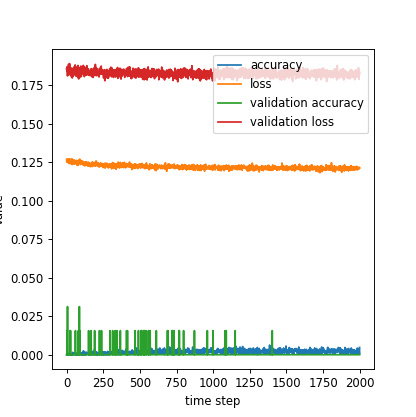

done


In [109]:
print('training. . .')
hist = generator.train(cube_dim,parse_dim, n_epochs = n_epochs,train_split = train_split, verbose=1)
print('done')

<IPython.core.display.Javascript object>


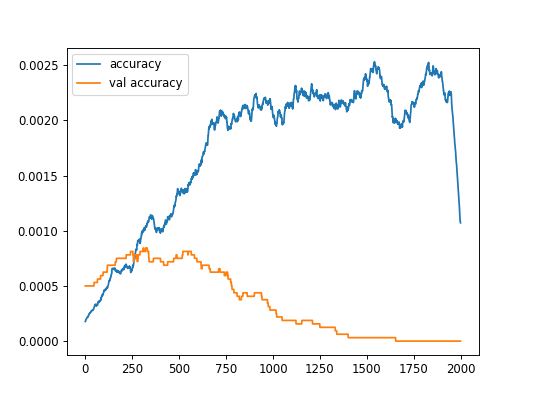

In [143]:
plt.figure()
plt.plot(list(range(2000)),smooth_data(hist.history['accuracy'],kernel_size=100),label='accuracy')
plt.plot(list(range(2000)),smooth_data(hist.history['val_accuracy'],kernel_size=500),label='val accuracy')
plt.legend()
plt.show()

MSE loss: 0.1904735118150711
predicted graph: 


<IPython.core.display.Javascript object>


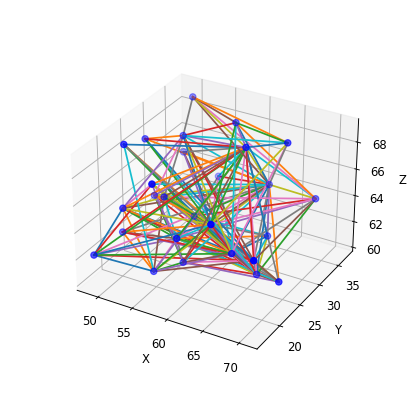

empirical graph: 


<IPython.core.display.Javascript object>


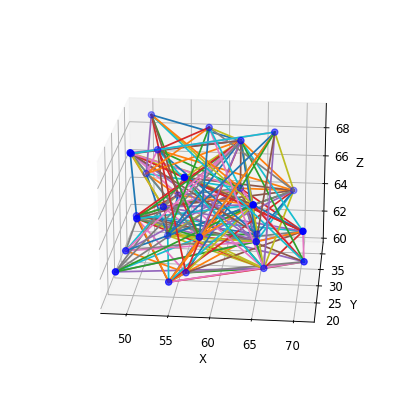

<IPython.core.display.Javascript object>


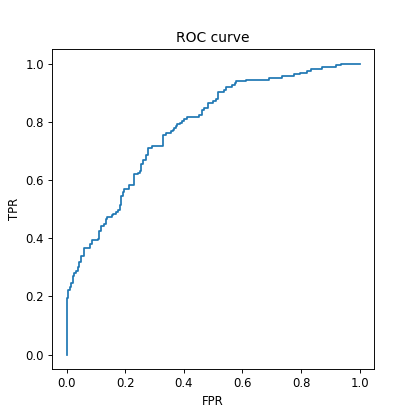

AROC: 0.781262237305836


In [125]:
generator.cube_test(cube_dim,parse_dim,train_split)

In [132]:
generator.load_model('val_three_by')

<IPython.core.display.Javascript object>


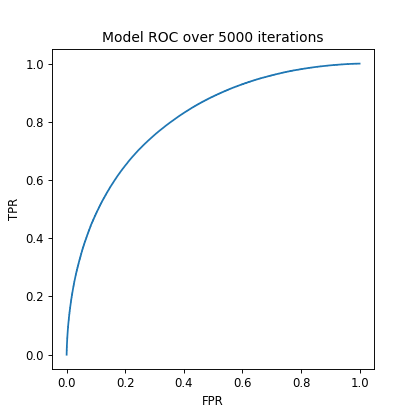

AROC: 0.807033432361774
average loss: 0.1822260618209839


In [126]:
generator.average_test(cube_dim,parse_dim, 5000, train_split)

<IPython.core.display.Javascript object>


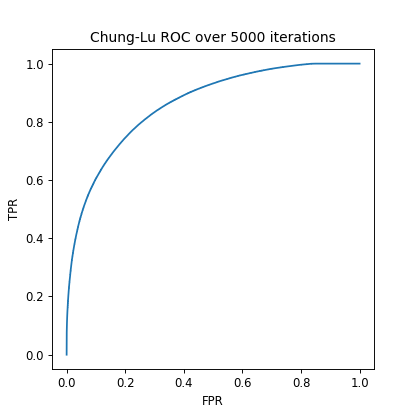

AROC: 0.8607214489326482


In [133]:
generator.average_chung_lu(cube_dim,parse_dim,5000,train_split)